In [36]:
%load_ext autoreload
%autoreload 2
#%matplotlib widget toggle for interractive 3d plot
import matplotlib.pyplot as plt
import numpy as np
from gp_backend import pdeGP,GPAggregate
from matplotlib import cm
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
def get_points(M):
    N=int(np.sqrt(M))
    interior_points=[]
    exterior_points=[]
    border=np.array([N-1,N-1])
    for i in range(N**2):
        point=[i%N,i//N]
        if np.prod(point)*np.prod(border-point)==0:
            exterior_points.append(point)
        else:
            interior_points.append(point)
    return np.array(interior_points)/(N-1),np.array(exterior_points)/(N-1)

def K(x1,x2,sigma):
    #try:
    #    sigma[1]
    #    raise Exception('Gaussian kernel only takes one parameter')
    #except IndexError:
    #    pass
    #s=sigma[0]
    return np.exp(-np.linalg.norm(x1-x2)**2/(2*sigma**2))

def DK(x1,x2,sigma):
    #try:
    #    sigma[1]
    #    raise Exception('Gaussian kernel only takes one parameter')
    #except IndexError:
    #    pass
    #s=sigma[0]
    n=np.linalg.norm(x1-x2)**2
    return (n-2*sigma**2)*np.exp(-n/(2*sigma**2))/sigma**4

def DDK(x1,x2,sigma):
    #try:
    #    sigma[1]
    #    raise Exception('Gaussian kernel only takes one parameter')
    #except IndexError:
    #    pass
    #s=sigma[0]
    n=np.linalg.norm(x1-x2)**2
    return (n**2+(sigma**2-n)*8*sigma**2)*np.exp(-n/(2*sigma**2))/sigma**8

tau=lambda x: 0
grad_tau=lambda x:0
g=lambda x:0
sol=lambda x: np.prod(np.sin(np.pi*x))+4*np.prod(np.sin(4*np.pi*x))
f=lambda x: -2*np.pi**2*np.prod(np.sin(np.pi*x))-4*(2*(4*np.pi)**2)*np.prod(np.sin(4*np.pi*x))
M=256
interior_points,exterior_points=get_points(M)
sigma=1.5e-1

In [40]:
GP=pdeGP(
    interior_collocation_points=interior_points[:100],
    exterior_collocation_points=exterior_points[:100],
    K=lambda x,y : K(x,y,sigma),
    DK=lambda x,y : DK(x,y,sigma),
    DDK=lambda x,y : DDK(x,y,sigma),
    g=g,
    f=f,
    tau=tau,
    grad_tau=grad_tau
)

In [69]:
np.exp(-np.linalg.norm(interior_points,axis=-1)/2)

(196,)

In [67]:
interior_points.shape

(196, 2)

In [41]:
GP.fit([1])


In [42]:
x_tests=np.array([
    [0.74581243,0.90903461],
    [0.30131835, 0.12985883],
    [0.35894375, 0.59591908],
    [0.29543396, 0.58845053],
    [0.65938026, 0.67829669],
    [0.53428125, 0.48339666],
    [0.60020676, 0.54059489],
    [0.59559422, 0.12332221],
    [0.32582677, 0.38427378],
    [0.12311113, 0.90784369],
])
for x_test in x_tests:
    #print(x_test)
    print(GP(x_test),sol(x_test))

-0.10028891572986547 0.01049797622046661
-2.1364657571608765 -2.0780137538141137
-2.5864910848188503 -2.7973754447240706
-0.986077435958803 -1.167871524284299
1.5334997178898309 3.590960779701608
-0.30819172532478384 0.6468673103071678
1.0485241179201765 2.802264997536838
3.9960513398906077 4.090067218796476
3.9210248114597 4.036379017193765
-0.22032759853334086 -3.555405917745984


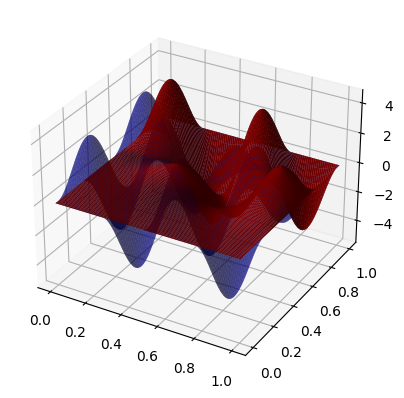

In [43]:
import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure()
ax = fig.add_subplot(projection='3d')


x=np.linspace(0,1,100)
y=np.linspace(0,1,100)

X, Y = np.meshgrid(x, y)
fxy = np.array([[sol(np.array([x,y])) for x,y in zip(X1,Y1)] for X1,Y1 in zip(X,Y)])
gxy = np.array([[GP(np.array([x,y])) for x,y in zip(X1,Y1)] for X1,Y1 in zip(X,Y)])


ax.plot_surface(X,Y,gxy, rstride=1, cstride=1, alpha=0.5, linewidth=0, facecolors=cm.jet(np.zeros((x.shape[0],y.shape[0]))),antialiased=True,label='true solution')
ax.plot_surface(X,Y,gxy-fxy, rstride=1, cstride=1, alpha=1.0, linewidth=0, facecolors=cm.jet(np.ones((x.shape[0],y.shape[0]))),antialiased=True,label='GP')

# Set an equal aspect ratio
#ax.set_aspect('equal')

plt.show()

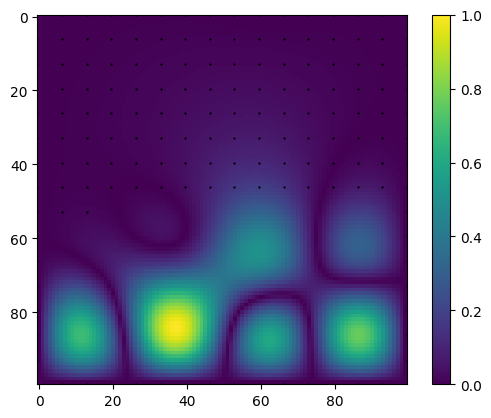

In [46]:
plt.imshow(np.abs(gxy-fxy))
points=np.concatenate([interior_points[:100],exterior_points[:100]])*100-0.5
plt.scatter(points[:,0],points[:,1],s=0.4,c='k')
plt.colorbar()

In [57]:
interior_points_2,exterior_points_2=interior_points[100:],exterior_points[100:]#get_points(64)

GP_2=pdeGP(
    interior_collocation_points=interior_points_2,
    exterior_collocation_points=exterior_points_2,
    K=lambda x,y : K(x,y,[sigma]),
    DK=lambda x,y : DK(x,y,[sigma]),
    DDK=lambda x,y : DDK(x,y,[sigma]),
    g=g,
    f=f,
    tau=tau,
    grad_tau=grad_tau
)
GP_2.fit([1])

In [58]:
agregate=GPAggregate([GP,GP_2])

In [60]:
import cProfile
cProfile.run("np.array([[agregate(np.array([x,y])) for x,y in zip(X1,Y1)] for X1,Y1 in tqdm(zip(X,Y))])")

100it [05:10,  3.10s/it]

         295055997 function calls in 310.208 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
 12800000   50.076    0.000  141.200    0.000 1308764289.py:14(K)
  9800000   44.272    0.000  113.402    0.000 1308764289.py:23(DK)
  4800000    2.569    0.000   55.837    0.000 2116944355.py:6(<lambda>)
  4800000    2.610    0.000   58.112    0.000 2116944355.py:7(<lambda>)
  8000000    4.106    0.000   92.038    0.000 228773776.py:4(<lambda>)
  5000000    2.759    0.000   60.659    0.000 228773776.py:5(<lambda>)
    80000    0.129    0.000    0.436    0.000 <__array_function__ internals>:177(dot)
    10000    0.016    0.000    0.432    0.000 <__array_function__ internals>:177(inv)
 22600000   16.242    0.000  160.253    0.000 <__array_function__ internals>:177(norm)
        1    0.001    0.001  310.252  310.252 <string>:1(<listcomp>)
        1    0.000    0.000  310.254  310.254 <string>:1(<module>)
        1    0.000    0.000   

0it [00:00, ?it/s]

computing a new covariance matrix
computing a new covariance matrix
computing a new covariance matrix


100it [03:08,  1.89s/it]


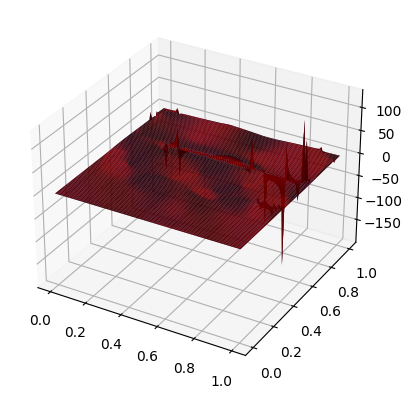

In [59]:



fig = plt.figure()
ax = fig.add_subplot(projection='3d')


x=np.linspace(0,1,100)
y=np.linspace(0,1,100)

X, Y = np.meshgrid(x, y)
fxy_2 = np.array([[sol(np.array([x,y])) for x,y in zip(X1,Y1)] for X1,Y1 in zip(X,Y)])
gxy_2 = np.array([[agregate(np.array([x,y])) for x,y in zip(X1,Y1)] for X1,Y1 in tqdm(zip(X,Y))])


ax.plot_surface(X,Y,gxy_2, rstride=1, cstride=1, alpha=0.5, linewidth=0, facecolors=cm.jet(np.zeros((x.shape[0],y.shape[0]))),antialiased=True,label='true solution')
ax.plot_surface(X,Y,gxy_2-fxy_2, rstride=1, cstride=1, alpha=1.0, linewidth=0, facecolors=cm.jet(np.ones((x.shape[0],y.shape[0]))),antialiased=True,label='GP')

# Set an equal aspect ratio
#ax.set_aspect('equal')

plt.show()

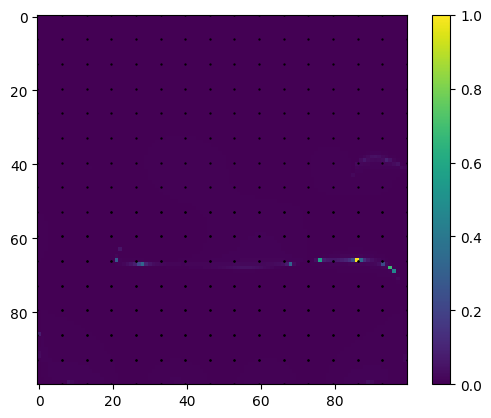

In [51]:
plt.imshow(np.abs(gxy_2-fxy_2))
points=np.concatenate([interior_points,exterior_points,interior_points_2,exterior_points_2])*100-0.5
plt.scatter(points[:,0],points[:,1],s=0.4,c='k')
plt.colorbar()

In [52]:
np.max(np.abs(gxy_2-fxy_2))

192.900300094235

In [55]:
np.max(gxy_2)

130.22204203522415

In [56]:
np.min(fxy_2)

-3.852810864198704